In [117]:
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob

from numpy.random import poisson, beta, uniform

import occSimFuncs as occFunc

%matplotlib inline

In [146]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.

consts = {'sigma_threshold': 7}

In [147]:
def make_allplanets_df_vec(df,starid_zp):
    # lets refector the above code to make it array operations
    totalRows = df.loc[:, 'Nplanets'].sum()

    df.loc[:, 'planetRadius'] = pd.Series()
    df.loc[:, 'planetPeriod'] = pd.Series()
    df.loc[:, 'starID'] = pd.Series()

    radper_dressing = occFunc.Dressing15_select(totalRows)
    radper_fressin = occFunc.Fressin13_select(totalRows)

    #we need an array of indices
    totalRows = df.loc[:, 'Nplanets'].sum()
    rowIdx = np.repeat(np.arange(df.shape[0]),np.array(df.Nplanets.values))

    newdf = df.iloc[rowIdx]
    newdf.loc[:, 'starID'] = rowIdx + starid_zp


    newdf.loc[:,'planetRadius'] = np.where(newdf.isMdwarf,radper_dressing[0],radper_fressin[0])
    newdf.loc[:,'planetPeriod'] = np.where(newdf.isMdwarf,radper_dressing[1],radper_fressin[1])
    newdf.set_index(np.arange(newdf.shape[0]), inplace=True)

    return newdf, newdf.starID.iloc[-1]

In [148]:
# load the targets
fn = '../data/selected.csv.bz2'
df = pd.read_csv(fn)

/Users/tom/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [149]:
# some things we are going to need later
df['isMdwarf'] = np.where((df.TEFF < 3900) & (df.RADIUS < 0.5), True, False)
df['isGiant'] = np.ones(df.shape[0], dtype='bool') # assume all dwarfs

df['tess_ccd'] = np.zeros(df.shape[0], dtype='int') 
df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 6) & (np.abs(df.ECLAT) < 30), 1, df.tess_ccd)
df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 30) & (np.abs(df.ECLAT) < 54), 2, df.tess_ccd)
df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 54) & (np.abs(df.ECLAT) < 78), 3, df.tess_ccd)
df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 78) & (np.abs(df.ECLAT) < 90), 4, df.tess_ccd) # spins on axis

# there are some dodgy assumptions here, which we can fix later
# we probably want to use tvguide
df['obs_len'] = np.zeros(df.shape[0], dtype='int') 
df['obs_len'] =  np.where(df.tess_ccd == 1, 27.4, df.obs_len)
df['obs_len'] =  np.where(df.tess_ccd == 4, 27.4*13., df.obs_len)

# ccd 2 and 3 are harder, we are going to do something stupid and wrong for now
df['obs_len'] =  np.where(df.tess_ccd == 2, 27.4, df.obs_len)
df['obs_len'] =  np.where(df.tess_ccd == 2, 27.4*2, df.obs_len)

# this cosi will be the same for every planet in the system
df['cosi'] = pd.Series(np.random.random(size=df.shape[0]),name='cosi')

In [150]:
# def component_noise(tmag):
sys = 59.785
star_mag_level, star_noise_level = np.array([
    [4.3885191347753745, 12.090570910640581],
    [12.023294509151416, 467.96434635620614],
    [17.753743760399338, 7779.603209291808]]).T
star_pars = np.polyfit(star_mag_level, np.log10(star_noise_level), 1)
zodi_mag_level, zodi_noise_level = np.array([
    [8.686356073211314, 18.112513551189224],
    [13.08901830282862, 688.2812796087189],
    [16.68801996672213, 19493.670323892282]]).T
zodi_pars = np.polyfit(zodi_mag_level, np.log10(zodi_noise_level), 1)
read_mag_level, read_noise_level = np.array([
    [8.476705490848586, 12.31474807751376],
    [13.019134775374376, 522.4985702369348],
    [17.841098169717142, 46226.777232915076]]).T
read_pars = np.polyfit(read_mag_level, np.log10(read_noise_level), 1)



    

(10, 16)

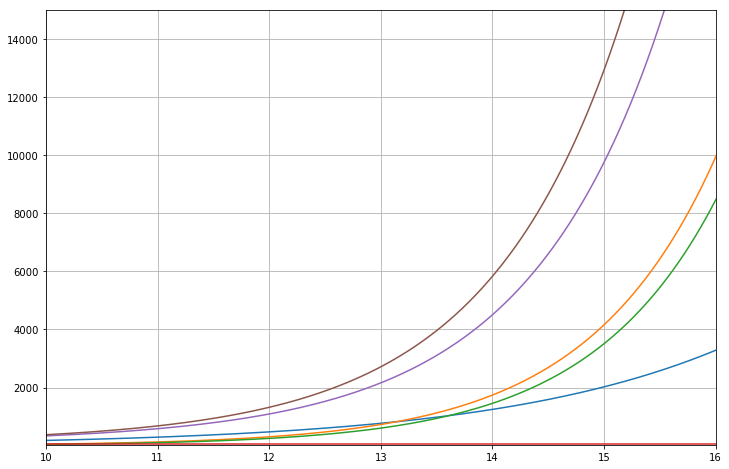

In [151]:
fig, ax = plt.subplots(1,1, figsize=[12,8])
x = np.arange(0,20,0.01)
plt.plot(x,10 ** (x * star_pars[0] + star_pars[1]))
plt.plot(x,10 ** (x * zodi_pars[0] + zodi_pars[1]))
plt.plot(x,10 ** (x * read_pars[0] + read_pars[1]))
plt.plot(x,np.repeat(sys,len(x)))

c1, c2, c3, c4 = 10 ** (x * star_pars[0] + star_pars[1]), 10 ** (x * zodi_pars[0] + zodi_pars[1]),10 ** (x * read_pars[0] + read_pars[1]),sys

plt.plot(x, c1 + c2 + c3 + c4)
plt.plot(x, c1 + np.sqrt(2)*c2 + np.sqrt(2)*c3 + c4)

# ax.set_yscale("log", nonposy='clip')
plt.ylim(30,15000)
plt.grid()
plt.xlim(10,16)

In [152]:
def component_noise(tessmag, readmod=1, zodimod=1):
    sys = 59.785
    star_mag_level, star_noise_level = np.array([
        [4.3885191347753745, 12.090570910640581],
        [12.023294509151416, 467.96434635620614],
        [17.753743760399338, 7779.603209291808]]).T
    star_pars = np.polyfit(star_mag_level, np.log10(star_noise_level), 1)
    zodi_mag_level, zodi_noise_level = np.array([
        [8.686356073211314, 18.112513551189224],
        [13.08901830282862, 688.2812796087189],
        [16.68801996672213, 19493.670323892282]]).T
    zodi_pars = np.polyfit(zodi_mag_level, np.log10(zodi_noise_level), 1)
    read_mag_level, read_noise_level = np.array([
        [8.476705490848586, 12.31474807751376],
        [13.019134775374376, 522.4985702369348],
        [17.841098169717142, 46226.777232915076]]).T
    read_pars = np.polyfit(read_mag_level, np.log10(read_noise_level), 1)
    
    c1, c2, c3, c4 = (10 ** (tessmag * star_pars[0] + star_pars[1]), 
                      10 ** (tessmag * zodi_pars[0] + zodi_pars[1]),
                      10 ** (tessmag * read_pars[0] + read_pars[1]), sys)
    
    return np.sqrt(c1**2 + (readmod*c2)**2 + (zodimod*c3)**2 + c4**2)





In [153]:
df['noise_level'] = component_noise(df.TESSMAG, readmod=1, zodimod=1)

In [154]:
# how many planets should each star get
np_fgk = poisson(lam=0.689,size=df.shape[0])
np_m = poisson(lam=2.5,size=df.shape[0])
df['Nplanets'] = pd.Series(np.where(df.isMdwarf, np_m, np_fgk), name='Nplanets')

In [155]:
# draw a bunch of planest and accociate them with each star
starID = 0 # ???
newDF, starID = make_allplanets_df_vec(df, starID)

# get some transit epochs
newDF = newDF.assign(T0=pd.Series(uniform(0, 1, size=newDF.shape[0]) * newDF.loc[:, 'planetPeriod']))

#calculate the number of transits
nt1 = np.floor(newDF['obs_len'] / newDF.planetPeriod)
newDF['Ntransits'] = np.where(newDF['T0'] < newDF['obs_len'] % newDF.planetPeriod, nt1+1,nt1)
newDF['ars'] = occFunc.per2ars(newDF.planetPeriod, newDF.MASS, newDF.RADIUS)
newDF['ecc'] = pd.Series(beta(1.03,13.6,size=newDF.shape[0]),name='ecc', ) # ecc dist from Van Eylen 2015
newDF['omega'] = pd.Series(uniform(-np.pi,np.pi,size=newDF.shape[0]),name='omega')
newDF['rprs'] = occFunc.get_rprs(newDF.planetRadius, newDF.RADIUS)
newDF['impact'] = newDF.cosi * newDF.ars * ((1-newDF.ecc**2)/1+newDF.ecc*np.sin(newDF.omega)) # cite Winn
newDF['duration'] = occFunc.get_duration(newDF.planetPeriod, newDF.ars, cosi=newDF.cosi, b=newDF.impact,
                                rprs=newDF.rprs) # cite Winn
newDF['duration_correction'] = np.sqrt(newDF.duration * 24.) # correction for CDPP because transit dur != 1 hour
newDF['transit_depth']  = occFunc.get_transit_depth(newDF.planetRadius, newDF.RADIUS)

newDF['transit_depth_diluted']  = newDF['transit_depth'] / (1+newDF.CONTRATIO)

/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:27: RuntimeWarning: invalid value encountered in sqrt
  part3 = np.sqrt((1 + rprs)**2 - b**2)


In [156]:
# now lets see if those planets are detected
newDF['needed_for_detection'] = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(newDF.Ntransits)) / consts['sigma_threshold']

newDF['has_transits']  = (newDF.ars > 1.0) & (newDF.impact < 1.0)

In [157]:
newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits


total_planets = newDF.detected.sum()

In [158]:
total_planets

733

In [159]:
mag_level, noise_level = np.genfromtxt('TessNoise_1h_v2.csv', delimiter=',',
                                           unpack=True,
                                           comments='#')

(8, 17)

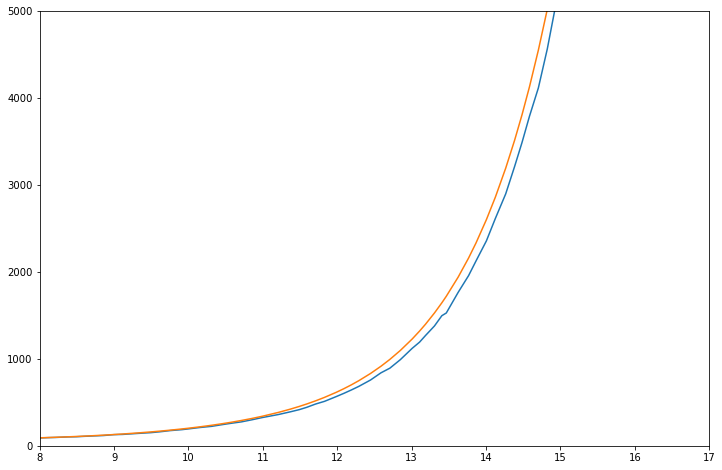

In [160]:
fig, ax = plt.subplots(1,1, figsize=[12,8])
plt.plot(mag_level, noise_level)
plt.plot(mag_level, component_noise(mag_level))
plt.ylim(0,5000)
plt.xlim(8,17)
# ax.set_yscale("log", nonposy='clip')

In [161]:
detected_DF = newDF[newDF.detected == True]

(array([   0.,    9.,   73.,   79.,   87.,   91.,   74.,  103.,   13.,
          16.,   14.,   17.,    9.,    8.,    9.,    9.,    9.,    5.,    5.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5]),
 <a list of 19 Patch objects>)

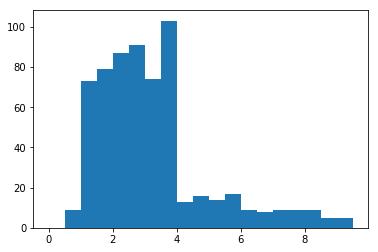

In [162]:
plt.hist(detected_DF.planetRadius, bins=np.arange(0,10,0.5))

(array([ 491.,  125.,   48.,   24.,   15.,   12.,    6.,   11.,    1.,    0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <a list of 10 Patch objects>)

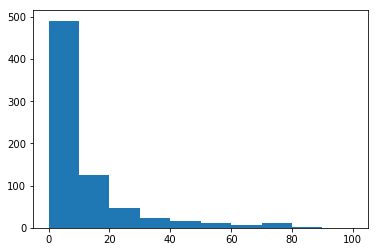

In [163]:
plt.hist(detected_DF.planetPeriod, np.arange(0,110,10))

(array([  25.,  113.,   68.,   68.,   37.,   23.,   28.,   45.,   58.,
          45.,   85.,   62.,   33.,   20.,    7.,    4.,    2.,    4.,
           0.,    1.,    1.,    4.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9]),
 <a list of 29 Patch objects>)

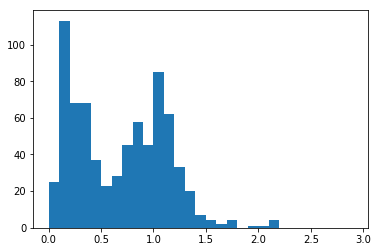

In [164]:
plt.hist(detected_DF.RADIUS, np.arange(0,3,0.1))

(array([ 5677.,  2146.,  1146.,   730.,   515.,   366.,   284.,   233.,
          171.,   145.,   112.,   104.,    68.,    62.,    61.,    52.,
           48.,    42.,    32.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5]),
 <a list of 19 Patch objects>)

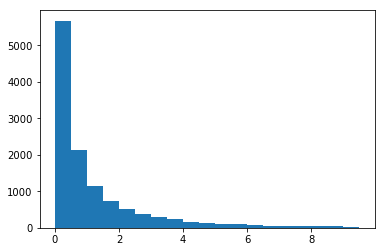

In [165]:
q = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(newDF.Ntransits)) / newDF.noise_level

plt.hist(q[np.isfinite(q)]  , np.arange(0,10,0.5))

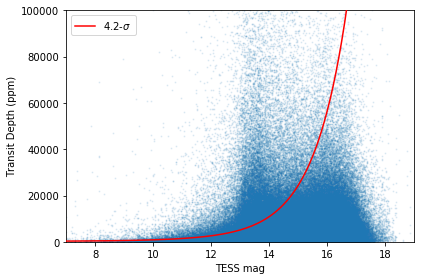

In [177]:
x = np.arange(0,20,0.1)

plt.scatter(newDF.TESSMAG, newDF.transit_depth_diluted * np.sqrt(newDF.obs_len / newDF.planetPeriod),  
            s=1, alpha=0.1)
plt.plot(x, component_noise(x) * 4.2, zorder=100, color='r', label='4.2-$\sigma$')
plt.ylim(0,100000)
plt.xlim(7,19)
plt.xlabel('TESS mag')
plt.ylabel('Transit Depth (ppm)')
plt.legend()
plt.tight_layout()
# plt.savefig('transitnoise.png', dpi=150)


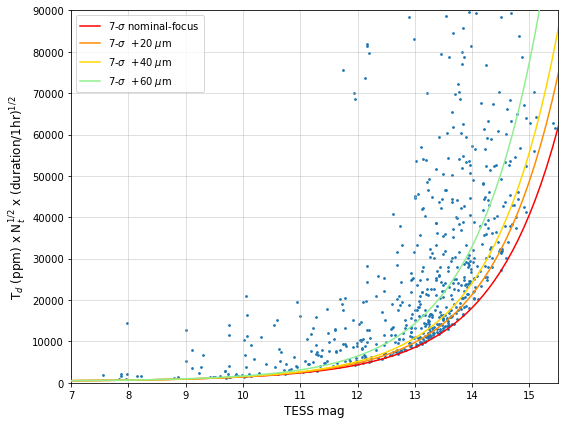

In [573]:
x = np.arange(0,20,0.1)
fig, ax = plt.subplots(1,1, figsize=[8,6])
# plt.scatter(detected_DF.TESSMAG, detected_DF.transit_depth_diluted * np.sqrt(detected_DF.Ntransits) * detected_DF.duration_correction,  
#             s=1, alpha=1)
# plt.plot(x, component_noise(x) * 7, zorder=100, color='gold', label='4-$\sigma$ good-focus')
# plt.plot(x, component_noise(x, readmod=np.sqrt(1.5), zodimod=np.sqrt(1.5)) * 7, 
#          zorder=100, color='darkorange', label='4-$\sigma$  medium-focus')
# plt.plot(x, component_noise(x, readmod=np.sqrt(2), zodimod=np.sqrt(2)) * 7, 
#          zorder=100, color='r', label='4-$\sigma$  bad-focus')

plt.scatter(detected_DF.TESSMAG, detected_DF.transit_depth_diluted * np.sqrt(detected_DF.Ntransits) * detected_DF.duration_correction,  
            s=3, alpha=1)
plt.plot(x, component_noise(x) * 7, zorder=100, label='7-$\sigma$ nominal-focus', color='red')
plt.plot(x, component_noise(x, readmod=np.sqrt(1.5), zodimod=np.sqrt(1.5)) * 7, 
         zorder=100, label='7-$\sigma$  +20 $\mu$m', color='darkorange')
plt.plot(x, component_noise(x, readmod=np.sqrt(2), zodimod=np.sqrt(2)) * 7, 
         zorder=100, label='7-$\sigma$  +40 $\mu$m', color='gold')
plt.plot(x, component_noise(x, readmod=np.sqrt(4), zodimod=np.sqrt(4)) * 7, 
         zorder=100, label='7-$\sigma$  +60 $\mu$m', color='lightgreen')

plt.ylim(0,90000)
plt.xlim(7,15.5)
plt.xlabel('TESS mag', fontsize=12)
plt.ylabel('T$_d$ (ppm) x N$_t^{1/2}$ x (duration/1hr)$^{1/2}$', fontsize=12)
plt.legend()
# ax.set_yscale("log", nonposy='clip')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('transitnoise_detected.png', dpi=250)


In [251]:
dd = detected_DF.transit_depth_diluted * np.sqrt(detected_DF.Ntransits) * detected_DF.duration_correction

In [570]:
notdetected_DF = detected_DF[component_noise(detected_DF.TESSMAG, readmod=np.sqrt(1.5), zodimod=np.sqrt(1.5)) * 7 > dd ]
maybedetected_DF = detected_DF[(component_noise(detected_DF.TESSMAG, readmod=np.sqrt(2.0), zodimod=np.sqrt(2.0)) * 7 > dd)
                              & (component_noise(detected_DF.TESSMAG, readmod=np.sqrt(1.5), zodimod=np.sqrt(1.5)) * 7 < dd)]
stilldetected_DF = detected_DF[component_noise(detected_DF.TESSMAG, readmod=np.sqrt(2), zodimod=np.sqrt(2)) * 7 < dd ]

superbad_DF = detected_DF[component_noise(detected_DF.TESSMAG, readmod=np.sqrt(2*2), zodimod=np.sqrt(2*2)) * 7 < dd ]


In [575]:
print(notdetected_DF.shape[0])
print(maybedetected_DF.shape[0])
print(stilldetected_DF.shape[0])
print(superbad_DF.shape[0])
print()
print(notdetected_DF.shape[0] / detected_DF.shape[0])
print(maybedetected_DF.shape[0] / detected_DF.shape[0])
print(stilldetected_DF.shape[0] / detected_DF.shape[0])
print(superbad_DF.shape[0] / detected_DF.shape[0])

103
68
562
432

0.14051841746248295
0.0927694406548431
0.7667121418826739
0.5893587994542974


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
          2.,   2.,   8.,  12.,  33.,  19.,   9.,   9.,   2.,   3.,   1.]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5]),
 <a list of 33 Patch objects>)

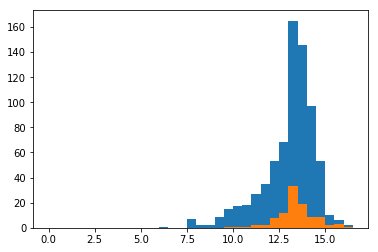

In [385]:

plt.hist(detected_DF.TESSMAG, bins=np.arange(0,17,0.5), histtype='barstacked', stacked=False)
plt.hist(notdetected_DF.TESSMAG, bins=np.arange(0,17,0.5), histtype='barstacked', stacked=False)

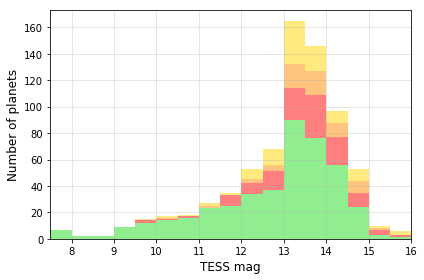

In [579]:
data1= np.histogram(stilldetected_DF.TESSMAG, bins=np.arange(0,17,0.5))
plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='r', align='edge')

data2= np.histogram(maybedetected_DF.TESSMAG, bins=np.arange(0,17,0.5))
plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='darkorange', bottom=data1[0], align='edge')
plt.xlim(7.5,16)

data3= np.histogram(notdetected_DF.TESSMAG, bins=np.arange(0,17,0.5))
plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, color='gold', bottom=data2[0] + data1[0], 
        align='edge')

data4= np.histogram(superbad_DF.TESSMAG, bins=np.arange(0,17,0.5))
plt.bar(data4[1][:-1], data4[0], width=0.5, label='data 1', alpha=1, color='lightgreen',
        align='edge')

# data1= np.histogram(stilldetected_DF.TESSMAG, bins=np.arange(0,17,0.5))
# plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5,  align='edge')

# data2= np.histogram(maybedetected_DF.TESSMAG, bins=np.arange(0,17,0.5))
# plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5,  bottom=data1[0], align='edge')
# plt.xlim(7.5,16)

# data3= np.histogram(notdetected_DF.TESSMAG, bins=np.arange(0,17,0.5))
# plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, bottom=data2[0] + data1[0], 
#         align='edge')
plt.xlim(7.5,16)

plt.xlabel('TESS mag', fontsize=12)
plt.ylabel('Number of planets', fontsize=12)

plt.grid(alpha=0.4)

plt.tight_layout()
plt.savefig('lostplanets_mag.png', dpi=250)

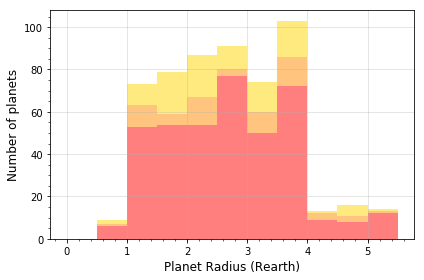

In [577]:
data1= np.histogram(stilldetected_DF.planetRadius, bins=np.arange(0,6,0.5))
plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='r', align='edge')

data2= np.histogram(maybedetected_DF.planetRadius, bins=np.arange(0,6,0.5))
plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='darkorange', bottom=data1[0], align='edge')


data3= np.histogram(notdetected_DF.planetRadius, bins=np.arange(0,6,0.5))
plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, color='gold', bottom=data2[0] + data1[0], 
        align='edge')

# data1= np.histogram(stilldetected_DF.planetRadius, bins=np.arange(0,6,0.5))
# plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, align='edge')

# data2= np.histogram(maybedetected_DF.planetRadius, bins=np.arange(0,6,0.5))
# plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, bottom=data1[0], align='edge')


# data3= np.histogram(notdetected_DF.planetRadius, bins=np.arange(0,6,0.5))
# plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, bottom=data2[0] + data1[0], 
#         align='edge')

# plt.xlim(7.5,16)

plt.xlabel('Planet Radius (Rearth)', fontsize=12)
plt.ylabel('Number of planets', fontsize=12)

plt.grid(alpha=0.4)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('lostplanets_planetradius.png', dpi=150)

<Container object of 11 artists>

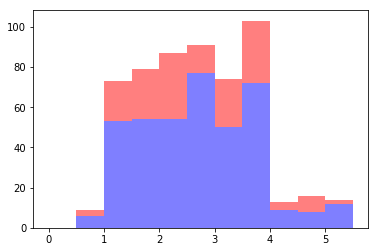

In [279]:
data1= np.histogram(stilldetected_DF.planetRadius, bins=np.arange(-0.,6,0.5))
plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='b', align='edge')

data2= np.histogram(notdetected_DF.planetRadius, bins=np.arange(0,6,0.5))
plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='r', bottom=data1[0], align='edge')


<Container object of 19 artists>

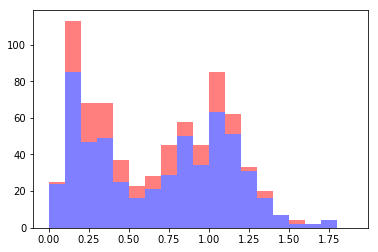

In [280]:
data1= np.histogram(stilldetected_DF.RADIUS, bins=np.arange(-0.,2,0.1))
plt.bar(data1[1][:-1], data1[0], width=0.1, label='data 1', alpha=0.5, color='b', align='edge')

data2= np.histogram(notdetected_DF.RADIUS, bins=np.arange(0,2,0.1))
plt.bar(data2[1][:-1], data2[0], width=0.1, label='data 1', alpha=0.5, color='r', bottom=data1[0], align='edge')


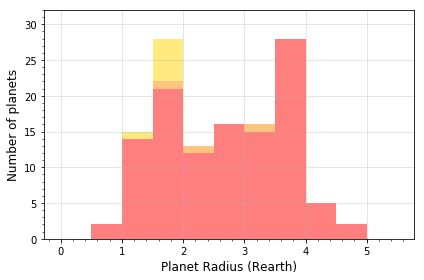

In [467]:
# data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.TESSMAG < 12.], bins=np.arange(-0.,4,0.5))
# plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='b', align='edge')

# data2= np.histogram(notdetected_DF.planetRadius[notdetected_DF.TESSMAG < 12.], bins=np.arange(0,4,0.5))
# plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='r', bottom=data1[0], align='edge')

# plt.grid()


data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='r', align='edge')

data2= np.histogram(maybedetected_DF.planetRadius[maybedetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='darkorange', bottom=data1[0], align='edge')


data3= np.histogram(notdetected_DF.planetRadius[notdetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, color='gold', bottom=data2[0] + data1[0], 
        align='edge')

# data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
# plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, align='edge')

# data2= np.histogram(maybedetected_DF.planetRadius[maybedetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
# plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, bottom=data1[0], align='edge')


# data3= np.histogram(notdetected_DF.planetRadius[notdetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
# plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, bottom=data2[0] + data1[0], 
#         align='edge')
# plt.xlim(7.5,16)
plt.ylim(0,32)

plt.xlabel('Planet Radius (Rearth)', fontsize=12)
plt.ylabel('Number of planets', fontsize=12)

plt.grid(alpha=0.4)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('lostplanets_planetradius_bright.png', dpi=250)

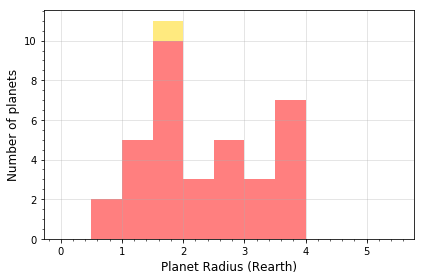

In [488]:
# data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.TESSMAG < 12.], bins=np.arange(-0.,4,0.5))
# plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='b', align='edge')

# data2= np.histogram(notdetected_DF.planetRadius[notdetected_DF.TESSMAG < 12.], bins=np.arange(0,4,0.5))
# plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='r', bottom=data1[0], align='edge')

# plt.grid()


data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.TESSMAG < 10.], bins=np.arange(0,6,0.5))
plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='r', align='edge')

data2= np.histogram(maybedetected_DF.planetRadius[maybedetected_DF.TESSMAG < 10.], bins=np.arange(0,6,0.5))
plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='darkorange', bottom=data1[0], align='edge')


data3= np.histogram(notdetected_DF.planetRadius[notdetected_DF.TESSMAG < 10.], bins=np.arange(0,6,0.5))
plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, color='gold', bottom=data2[0] + data1[0], 
        align='edge')

# data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
# plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, align='edge')

# data2= np.histogram(maybedetected_DF.planetRadius[maybedetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
# plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, bottom=data1[0], align='edge')


# data3= np.histogram(notdetected_DF.planetRadius[notdetected_DF.TESSMAG < 12.], bins=np.arange(0,6,0.5))
# plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, bottom=data2[0] + data1[0], 
#         align='edge')
# plt.xlim(7.5,16)
# plt.ylim(0,32)

plt.xlabel('Planet Radius (Rearth)', fontsize=12)
plt.ylabel('Number of planets', fontsize=12)

plt.grid(alpha=0.4)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('lostplanets_planetradius_verybright.png', dpi=250)

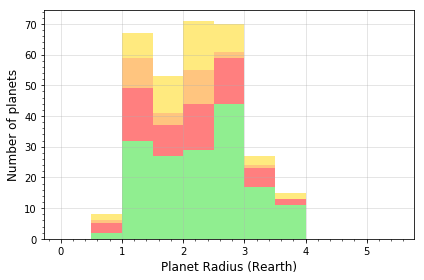

In [580]:
# data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.RADIUS < 0.5], bins=np.arange(-0.,4.5,0.5))
# plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='b', align='edge')

# data2= np.histogram(notdetected_DF.planetRadius[notdetected_DF.RADIUS < 0.5], bins=np.arange(0,4.5,0.5))
# plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='r', bottom=data1[0], align='edge')
# plt.xlabel('Planet Radius (Rearth)')
# plt.grid()



data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.RADIUS < 0.5], bins=np.arange(0,6,0.5))
plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, color='r', align='edge')

data2= np.histogram(maybedetected_DF.planetRadius[maybedetected_DF.RADIUS < 0.5], bins=np.arange(0,6,0.5))
plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, color='darkorange', bottom=data1[0], align='edge')

data3= np.histogram(notdetected_DF.planetRadius[notdetected_DF.RADIUS < 0.5], bins=np.arange(0,6,0.5))
plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, color='gold', bottom=data2[0] + data1[0], 
        align='edge')

data4= np.histogram(superbad_DF.planetRadius[superbad_DF.RADIUS < 0.5], bins=np.arange(0,6,0.5))
plt.bar(data4[1][:-1], data4[0], width=0.5, label='data 1', alpha=1, color='lightgreen', 
        align='edge')

# data1= np.histogram(stilldetected_DF.planetRadius[stilldetected_DF.RADIUS < 0.5], bins=np.arange(0,6,0.5))
# plt.bar(data1[1][:-1], data1[0], width=0.5, label='data 1', alpha=0.5, align='edge')

# data2= np.histogram(maybedetected_DF.planetRadius[maybedetected_DF.RADIUS < 0.5], bins=np.arange(0,6,0.5))
# plt.bar(data2[1][:-1], data2[0], width=0.5, label='data 1', alpha=0.5, bottom=data1[0], align='edge')


# data3= np.histogram(notdetected_DF.planetRadius[notdetected_DF.RADIUS < 0.5], bins=np.arange(0,6,0.5))
# plt.bar(data3[1][:-1], data3[0], width=0.5, label='data 1', alpha=0.5, bottom=data2[0] + data1[0], 
#         align='edge')
# plt.xlim(7.5,16)
# plt.ylim(0,32)

plt.xlabel('Planet Radius (Rearth)', fontsize=12)
plt.ylabel('Number of planets', fontsize=12)

plt.grid(alpha=0.4)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('lostplanets_planetradius_mdwarfs.png', dpi=250)

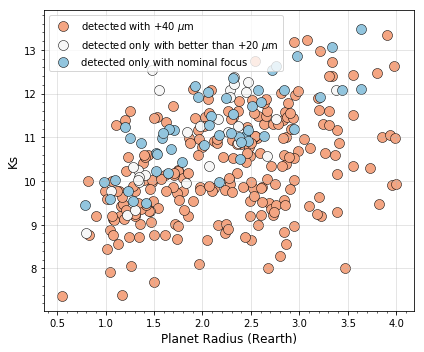

In [490]:
fig,ax  = plt.subplots(1,1,figsize=[6,5])

plt.scatter(stilldetected_DF.planetRadius[stilldetected_DF.RADIUS < 0.5], 
            stilldetected_DF.Ks[stilldetected_DF.RADIUS < 0.5], edgecolor='k', linewidths=0.5,
            color='#f4a582', marker='o',s=100, label='detected with +40 $\mu$m')
plt.scatter(maybedetected_DF.planetRadius[maybedetected_DF.RADIUS < 0.5], 
            maybedetected_DF.Ks[maybedetected_DF.RADIUS < 0.5], edgecolor='k', linewidths=0.5,
            color='#f7f7f7', marker='o',s=100, label='detected only with better than +20 $\mu$m')

plt.scatter(notdetected_DF.planetRadius[notdetected_DF.RADIUS < 0.5], 
            notdetected_DF.Ks[notdetected_DF.RADIUS < 0.5], edgecolor='k', linewidths=0.5,
            color='#92c5de', marker='o',s=100, label='detected only with nominal focus')


plt.ylabel('Ks', fontsize=12)
plt.xlabel('Planet Radius (Rearth)', fontsize=12)

plt.grid(alpha=0.4)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('lostplanets_planetradius_ks_mdwarfs.png', dpi=250)

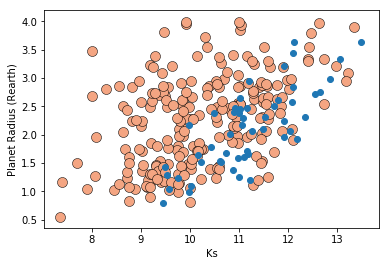

In [454]:
plt.scatter(stilldetected_DF.Ks[stilldetected_DF.RADIUS < 0.5], 
            stilldetected_DF.planetRadius[stilldetected_DF.RADIUS < 0.5])
plt.scatter( 
            notdetected_DF.Ks[notdetected_DF.RADIUS < 0.5],
            notdetected_DF.planetRadius[notdetected_DF.RADIUS < 0.5])

plt.xlabel('Ks')
plt.ylabel('Planet Radius (Rearth)')



(0, 0.1)

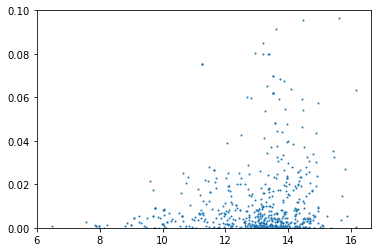

In [320]:
plt.scatter(detected_DF.TESSMAG,detected_DF.CONTRATIO, s=1)
plt.ylim(0,0.1)

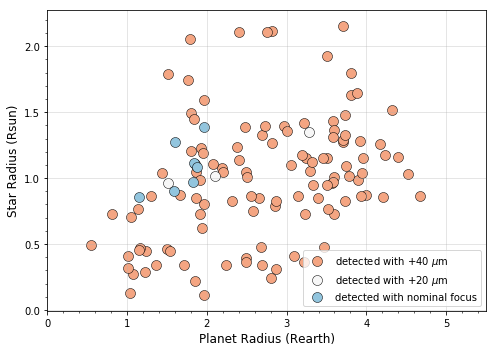

In [492]:
fig,ax  = plt.subplots(1,1,figsize=[7,5])

vv = stilldetected_DF[stilldetected_DF.TESSMAG < 12.]
vv1 = maybedetected_DF[maybedetected_DF.TESSMAG < 12.]
vv2 = notdetected_DF[notdetected_DF.TESSMAG < 12.]
plt.scatter(vv.planetRadius, vv.RADIUS, edgecolor='k', linewidths=0.5,
            color='#f4a582', marker='o',s=100, label='detected with +40 $\mu$m')
plt.scatter(vv1.planetRadius, vv1.RADIUS, edgecolor='k', linewidths=0.5,
            color='#f7f7f7', marker='o',s=100, label='detected with +20 $\mu$m')
plt.scatter(vv2.planetRadius, vv2.RADIUS, edgecolor='k', linewidths=0.5,
            color='#92c5de', marker='o',s=100, label='detected with nominal focus')

plt.xlim(0,5.5)

plt.ylabel('Star Radius (Rsun)', fontsize=12)
plt.xlabel('Planet Radius (Rearth)', fontsize=12)

plt.grid(alpha=0.4)
plt.minorticks_on()
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('lostplanets_planetradius_starradius_bright.png', dpi=250)

(0, 5)

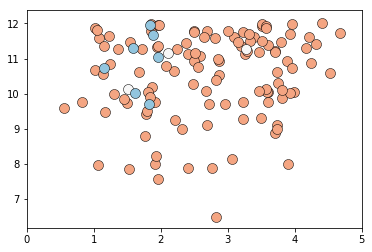

In [458]:
vv = stilldetected_DF[stilldetected_DF.TESSMAG < 12.]
vv1 = maybedetected_DF[maybedetected_DF.TESSMAG < 12.]
vv2 = notdetected_DF[notdetected_DF.TESSMAG < 12.]
plt.scatter(vv.planetRadius, vv.TESSMAG, edgecolor='k', linewidths=0.5,
            color='#f4a582', marker='o',s=100, label='detected with +40 $\mu$m')
plt.scatter(vv1.planetRadius, vv1.TESSMAG, edgecolor='k', linewidths=0.5,
            color='#f7f7f7', marker='o',s=100, label='detected only with better than +20 $\mu$m')
plt.scatter(vv2.planetRadius, vv2.TESSMAG, edgecolor='k', linewidths=0.5,
            color='#92c5de', marker='o',s=100, label='detected only with nominal focus')

plt.xlim(0,5)

/Users/tom/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


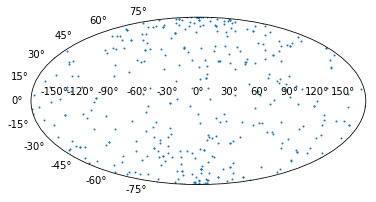

In [520]:
fig  = plt.subplot(111, projection="hammer")

plt.scatter(detected_DF.RA, detected_DF.DEC, s=1, alpha=1)

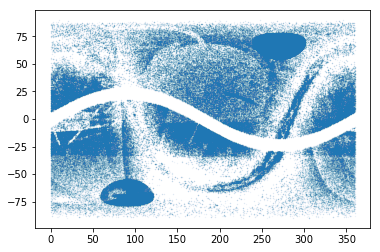

In [502]:

plt.scatter(newDF.RA, newDF.DEC, s=0.1, alpha=0.1)

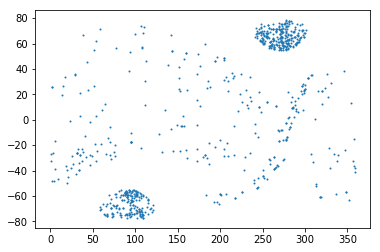

In [522]:
plt.scatter(detected_DF.RA, detected_DF.DEC, s=1, alpha=1)

In [543]:
def get_insol(teff, ars):
    p1 = (teff/5771)**4
    p2 = (215.1 / ars)**2
    return p1 * p2

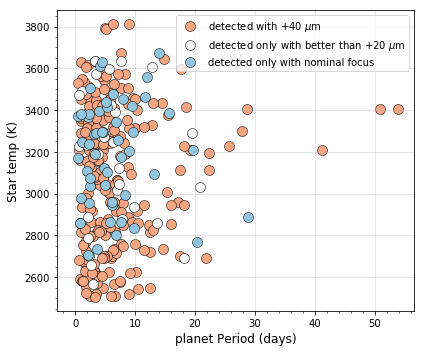

In [533]:
fig,ax  = plt.subplots(1,1,figsize=[6,5])


plt.scatter(stilldetected_DF.planetPeriod[stilldetected_DF.RADIUS < 0.5], 
            stilldetected_DF.TEFF[stilldetected_DF.RADIUS < 0.5], edgecolor='k', linewidths=0.5,
            color='#f4a582', marker='o',s=100, label='detected with +40 $\mu$m')
plt.scatter(maybedetected_DF.planetPeriod[maybedetected_DF.RADIUS < 0.5], 
            maybedetected_DF.TEFF[maybedetected_DF.RADIUS < 0.5], edgecolor='k', linewidths=0.5,
            color='#f7f7f7', marker='o',s=100, label='detected only with better than +20 $\mu$m')

plt.scatter(notdetected_DF.planetPeriod[notdetected_DF.RADIUS < 0.5], 
            notdetected_DF.TEFF[notdetected_DF.RADIUS < 0.5], edgecolor='k', linewidths=0.5,
            color='#92c5de', marker='o',s=100, label='detected only with nominal focus')


plt.xlabel('planet Period (days)', fontsize=12)
plt.ylabel('Star temp (K)', fontsize=12)

plt.grid(alpha=0.4)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
# plt.savefig('lostplanets_planetradius_ks_mdwarfs.png', dpi=250)

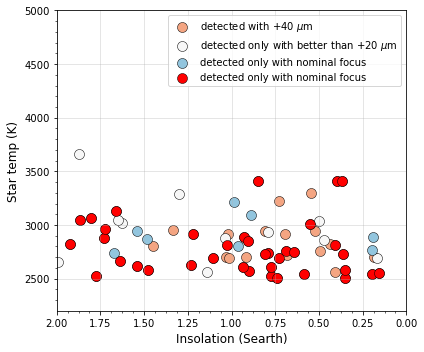

In [572]:
fig,ax  = plt.subplots(1,1,figsize=[6,5])


plt.scatter(get_insol(stilldetected_DF.TEFF[stilldetected_DF.planetRadius < 2.5], 
                      stilldetected_DF.ars[stilldetected_DF.planetRadius < 2.5]),
            stilldetected_DF.TEFF[stilldetected_DF.planetRadius < 2.5],
            edgecolor='k', linewidths=0.5,
            color='#f4a582', marker='o',s=100, label='detected with +40 $\mu$m')
plt.scatter(get_insol(maybedetected_DF.TEFF[maybedetected_DF.planetRadius < 2.5], 
                      maybedetected_DF.ars[maybedetected_DF.planetRadius < 2.5]),
            maybedetected_DF.TEFF[maybedetected_DF.planetRadius < 2.5],
            edgecolor='k', linewidths=0.5,
            color='#f7f7f7', marker='o',s=100, label='detected only with better than +20 $\mu$m')

plt.scatter(get_insol(notdetected_DF.TEFF[notdetected_DF.planetRadius < 2.5], 
                      notdetected_DF.ars[notdetected_DF.planetRadius < 2.5]),
            notdetected_DF.TEFF[notdetected_DF.planetRadius < 2.5], 
            edgecolor='k', linewidths=0.5,
            color='#92c5de', marker='o',s=100, label='detected only with nominal focus')

plt.scatter(get_insol(superbad_DF.TEFF[superbad_DF.planetRadius < 2.5], 
                      superbad_DF.ars[superbad_DF.planetRadius < 2.5]),
            superbad_DF.TEFF[superbad_DF.planetRadius < 2.5], 
            edgecolor='k', linewidths=0.5,
            color='r', marker='o',s=100, label='detected only with nominal focus')


plt.xlabel('Insolation (Searth)', fontsize=12)
plt.ylabel('Star temp (K)', fontsize=12)
plt.grid(alpha=0.4)
plt.xlim(2,0)
plt.ylim(2200, 5000)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
# plt.savefig('lostplanets_planetradius_ks_mdwarfs.png', dpi=250)

In [541]:
(5000/5771)**4 * (215.1/100)**2

2.6070931039959153